# Data Carpentry - Run in DMIR container or install sklearn

This notebook pulls the datasets from the database, combines them, drops sparse columns, countries, and years, and imputes the rest of the data using KNN. The output is completeDF.csv.

---

## **Import Libraries**

In [1]:
import numpy as np
import pandas as pd
from itertools import chain
import getpass
from sqlalchemy.engine.url import URL
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

## **Connect to DB**

In [2]:
username = input('Enter Username: ')

Enter Username: bmgwd9


In [3]:
#Connecting with SQLAlchemy
mypasswd = getpass.getpass()
#username = 'jyymn'
host = 'pgsql.dsa.lan'
database = 'caponl_22g3'

#SQLAlchemy Connection Parameters
postgres_db = {'drivername': 'postgres',
               'username': username,
               'password': mypasswd,
               'host': host,
               'database' :database}

engine = create_engine(URL(**postgres_db), echo=False)

········


In [4]:
##Connecting with SQL Magic
connection_string = f"postgres://{username}:{mypasswd}@{host}/{database}"
%load_ext sql
%sql $connection_string 

'Connected: bmgwd9@caponl_22g3'

In [5]:
del mypasswd

---

## Useful functions

### ***Function to remove "non-countries"***

In [6]:
def territory_removal(df):
    with engine.connect() as connection:
        #Reduce to 212 countries
        countrycodesDF = pd.read_csv("../../M1/initial_data/CountryCodesFinal.csv")
        
    onlycountriesDF = pd.merge(df, countrycodesDF, left_on="CountryCode", right_on="alpha3_code")
    
    return onlycountriesDF

### ***Function to load and clean DFs***

In [7]:
def df_load_and_clean(db_name):
    with engine.connect() as connection:
        df = pd.read_sql("SELECT * FROM " + db_name, connection)
        
    #Rename columsn to remove spaces
    cleanDF = df.rename(columns={"Country Name":"CountryName", "Country Code":"CountryCode", "variable":"Year"})
    
    #Drop the "index" column
    cleanDF = cleanDF.drop("index", axis=1)
    
    #Reduce to 212 countries
    cleanDF = territory_removal(cleanDF)
    
    return cleanDF

### ***Function to calculate null value statistics***

In [8]:
def nullstats(df):
    totalvalues = df.shape[0] * df.shape[1]
    totalnulls = df.isnull().sum().sum()
    propnull = totalnulls/totalvalues
    
    print("Total nulls: {:,}".format(totalnulls))
    print("Total cells: {:,}".format(totalvalues))
    print(round(propnull*100,2), "% of DF is null")

### ***Function to calculate number of null values in a column***

In [9]:
def nullcalculator(indicator):
    nulls = completeDF[indicator].isnull().sum()
    
    return nulls

---

## **Merging DFs/Adding POPCAGR**

### ***Load all DFs***

In [10]:
wdiDF = df_load_and_clean("WB_wdi")
popDF = df_load_and_clean("WB_pop")
hnpDF = df_load_and_clean("WB_hnp")
genderDF = df_load_and_clean("WB_gender")

### ***Merge all***

In [11]:
completeDF = pd.merge(popDF, hnpDF, on=["CountryCode", "Year"])
completeDF = pd.merge(completeDF, genderDF, on=["CountryCode", "Year"])
completeDF = pd.merge(completeDF, wdiDF, on=["CountryCode", "Year"])

In [12]:
completeDF.shape

(12931, 2143)

In [13]:
#27.7MM cells
completeDF.shape[0] * completeDF.shape[1]

27711133

In [14]:
#212 countries
len(completeDF.CountryCode.unique())

212

In [15]:
#Min year
completeDF.Year.min()

1960

In [16]:
#Max year
completeDF.Year.max()

2020

In [17]:
nullstats(completeDF) #69.15%

Total nulls: 19,163,559
Total cells: 27,711,133
69.15 % of DF is null


### ***Remove features duplicated in merge***

In [18]:
dupcolumns = []
for feature in completeDF.columns:
  if "_y" in feature:
    dupcolumns.append(feature)

print(len(dupcolumns), "duplicated columns")

#Drop
completeDF = completeDF.drop(dupcolumns, axis=1).reset_index(drop=True)

#Drop remaining duplicates - 6
completeDF = completeDF.loc[:, ~completeDF.columns.duplicated()]

#Rename duplicated columns (drop "_x")
completeDF.columns = [i.replace("_x", "") for i in completeDF.columns]

completeDF.shape

12 duplicated columns


(12931, 2125)

### *Add 'immigration' to DF*

In [19]:
total_births = round(completeDF['SPDYNCBRTIN'] * completeDF['SPPOPTOTL'] / 1000)
total_deaths = round(completeDF['SPDYNCDRTIN'] * completeDF['SPPOPTOTL'] / 1000)
net_pop = round(total_births - total_deaths)
yoy_totl_grow = completeDF.SPPOPTOTL.diff()

completeDF["IMMIGRATION"] = yoy_totl_grow - net_pop

In [20]:
nullstats(completeDF) #69.71%

Total nulls: 19,164,529
Total cells: 27,491,306
69.71 % of DF is null


---

# Variable Reduction

## Null values by Year

<Figure size 7200x7200 with 0 Axes>

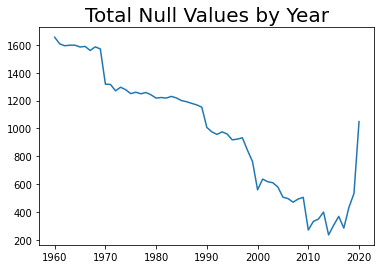

<Figure size 7200x7200 with 0 Axes>

In [21]:
#Examine
nabyyearDF = completeDF.groupby("Year").sum() < 1
plt.plot(nabyyearDF.sum(axis=1))
plt.title(label="Total Null Values by Year", fontdict={'size': 20})
plt.figure(figsize=(100,100))

### ***For the final completeDF, the start year is 1990 and cutoff is 2019***

All the null stats indicated going forward are for a 1990 cutoff

In [22]:
start_year = 1990
cutoff_year = 2019


completeDF = completeDF[completeDF["Year"] >= start_year]
print("DF min year: ", completeDF.Year.min())

completeDF = completeDF[completeDF["Year"] <= cutoff_year]
print("DF max year: ", completeDF.Year.max())

DF min year:  1990
DF max year:  2019


In [23]:
#Null value stats
nullstats(completeDF) #58.37% for 1990

Total nulls: 7,892,171
Total cells: 13,521,360
58.37 % of DF is null


## Null values by country

In [24]:
#Countries before operation
len(completeDF.CountryName.unique())

212

In [25]:
#Create a list of countries, calculate the number of null values for each and what % is missing
countries = []
totalcells = []
nas = []

for country in completeDF.CountryName.unique():
    countryDF = completeDF[completeDF["CountryName"] == country]
    countries.append(country)
    totalcells.append(countryDF.shape[0] * countryDF.shape[1])
    nas.append(countryDF.isna().sum().sum())
    
nabycountryDF = pd.DataFrame({"CountryName":countries, "NAs": nas, "TotalCells":totalcells})

nabycountryDF["%Missing"] = nabycountryDF["NAs"] * 100 / nabycountryDF["TotalCells"]

nabycountryDF = nabycountryDF.sort_values(by="%Missing").reset_index(drop=True)

In [26]:
#Group countries by how much data they are missing. Compute how much population is retained if said countries were 
#cut. Order by amount of missing data, highest to lowest
perc_missing = []
population = []
pop_retained = []
countries_cut = []
for i in np.arange(96,0,-.25):
    perc_missing.append(i)
    countriestofilter = nabycountryDF[nabycountryDF["%Missing"] > i]["CountryName"].values
    subpop = completeDF[(completeDF["CountryName"].isin(countriestofilter)) & (completeDF['Year'] == 2019)]['SPPOPTOTL'].sum()
    population.append(subpop)
    totalpop = completeDF[completeDF["Year"] == 2019]['SPPOPTOTL'].sum()
    pop_retained.append(round(1 - (subpop/totalpop), 3))
    countries_cut.append(len(countriestofilter))
    #print(i, "% or more data missing : ", round(1 - (subpop/ totalpop),3), "% population retained.", len(countriestofilter), "countries cut")

countriestocutDF = pd.DataFrame({"%Missing":perc_missing, "PopRetained":pop_retained, "CountriesCut":countries_cut})

<AxesSubplot:>

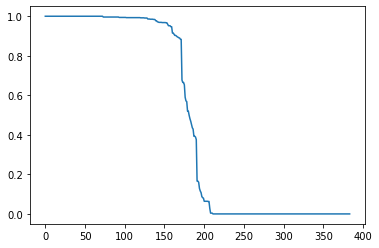

In [27]:
# Plot all
countriestocutDF['PopRetained'].plot() #Zoom for original: [30:36]

<AxesSubplot:>

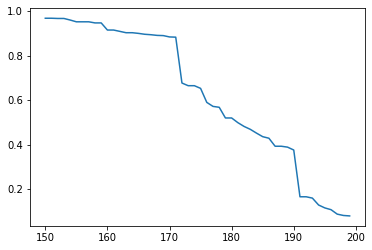

In [28]:
#Zoom
countriestocutDF['PopRetained'].iloc[150:200].plot()

In [29]:
#Examine 170 area
countriestocutDF.iloc[165:175]

,%Missing,PopRetained,CountriesCut
165,54.75,0.900,95
166,54.50,0.896,97
167,54.25,0.894,99
168,54.00,0.891,101
169,53.75,0.890,103
170,53.50,0.884,106
171,53.25,0.883,107
172,53.00,0.677,114
173,52.75,0.665,120
174,52.50,0.665,120


In [30]:
#Examine how much data we retain by cutting off at the 42nd line and how much missing data those countries have
countriestocutDF.iloc[171] #107 countries, missing 54% or more data, but retaining 88.3% of the population

%Missing         53.250
PopRetained       0.883
CountriesCut    107.000
Name: 171, dtype: float64

In [31]:
#Now filter the nabycountryDF for the 65% cutoff and store the list of countries to filter the entire DF
perc_missing =  53.25 #65.1 for 1970
countriestofilter = nabycountryDF[nabycountryDF["%Missing"] <= perc_missing]["CountryName"].values 

completeDF = completeDF[completeDF["CountryName"].isin(countriestofilter)]

In [32]:
#Null value stats
nullstats(completeDF) #49.93 for 1990

Total nulls: 3,343,959
Total cells: 6,696,900
49.93 % of DF is null


In [33]:
#Countries remaining
country_count = len(completeDF.CountryName.unique())
country_count #Should be 105 

105

## Null values by variable

In [34]:
#Generate a list of features in DF, how much data they are missing, percent they are missing, and how much
#is not missing
#Store this as a function so that a cleaned dataframe can be run through it again
def missing_values(df):
    features = []
    NAs = []
    for feature in df.columns:
        features.append(feature)
        NAs.append(nullcalculator(feature))
    naDF = pd.DataFrame({"feature":features, "missing":NAs})
    naDF['perc_missing'] = naDF["missing"] / df.shape[0]
    naDF['not_missing'] = df.shape[0] - naDF["missing"]
    naDF = naDF.sort_values(by="not_missing", ascending=False).reset_index(drop=True)
    #naDF['cum_missing'] = naDF["missing"].cumsum()
    
    return naDF

In [35]:
#Store initial completeDF results
nabyfeatureDF = missing_values(completeDF)
nabyfeatureDF.shape[0] 

2126

([<matplotlib.axis.XTick at 0x7f5bc5771dd8>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

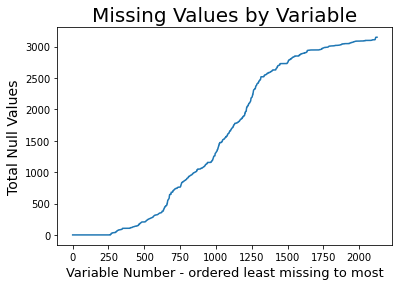

In [36]:
#Quick examination
#The variables are stored in order of how much data they are missing - from least to most
#Therefore, this plot shows the index of the variable in the DF (X-axis) and how much data it is missing (Y-axis)
plt.plot(nabyfeatureDF.missing)
plt.title("Missing Values by Variable", fontdict={'size':20})
plt.ylabel("Total Null Values", fontdict={'size':14})
plt.xlabel("Variable Number - ordered least missing to most", fontdict={'size':13})
plt.xticks(np.arange(0, 2200, step=250))

In [37]:
#Eliminating those missing 50% or more data
nabyfeatureDF = nabyfeatureDF[nabyfeatureDF["perc_missing"] <= .5]
nabyfeatureDF.shape[0] #1077 remaining from 1990

1077

<AxesSubplot:>

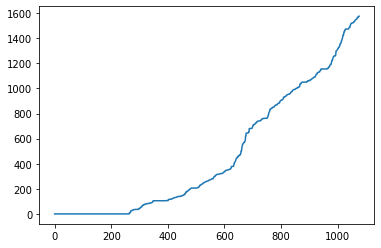

In [38]:
#Examine again
nabyfeatureDF.missing.plot()

<AxesSubplot:>

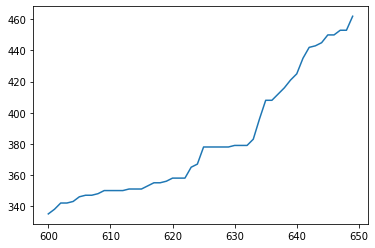

In [39]:
#Zoom
nabyfeatureDF.iloc[600:650].missing.plot() 

In [40]:
nabyfeatureDF.iloc[620:630]

,feature,missing,perc_missing,not_missing
620,SEPRMENRRFE,358,0.113651,2792
621,SEENRPRIMFMZS,358,0.113651,2792
622,SEPRMENRRMA,358,0.113651,2792
623,NVINDMANFKDZG,365,0.115873,2785
624,BNTRFKOGTCD,367,0.116508,2783
625,TMVALFUELZSUN,378,0.120000,2772
626,TMVALFOODZSUN,378,0.120000,2772
627,TMVALAGRIZSUN,378,0.120000,2772
628,TMVALMMTLZSUN,378,0.120000,2772
629,TMVALMANFZSUN,378,0.120000,2772


In [41]:
# Cutoff at 623
nabyfeatureDF = missing_values(completeDF).iloc[:624] 

nabyfeatureDF.tail(3) #Confirm

,feature,missing,perc_missing,not_missing
621,SEENRPRIMFMZS,358,0.113651,2792
622,SEPRMENRRMA,358,0.113651,2792
623,NVINDMANFKDZG,365,0.115873,2785


In [42]:
#Filter DF to include only those features remaining
completeDF = completeDF[nabyfeatureDF['feature']]

In [43]:
#Current null value stats
nullstats(completeDF) #3.13% for 1990

Total nulls: 61,543
Total cells: 1,965,600
3.13 % of DF is null


---

---

## Variables with 'fake' data (1's and 0's)

Some countries have data encoded with just 1s and 0s in places. There are some variables with a high number or almost
all 1s and 0s. This part of the notebook finds those variables with a high number of 1s and 0s and eliminates them.

In [44]:
#Find countries and variables with 1 and 0 encoding
fakesDF = pd.DataFrame()
for country in pd.unique(completeDF['CountryName']):
    ctrydf = completeDF[completeDF['CountryName'] == country]
    for met in ctrydf.columns:
        if {a for a in ctrydf[met]}==({0} or {0,1}):
            fakesDF = fakesDF.append(pd.DataFrame({'Country':[country], "Metric":[met]}))

In [45]:
#Create a DF from this that shows how much is 'missing' based on feature (both total and percent of total)
fakesbyfeatureDF = pd.DataFrame(columns=['feature', '#missing', '%missing'])
for metric in fakesDF["Metric"].unique():
    num_missing = fakesDF[fakesDF["Metric"] == metric].shape[0]
    fakesbyfeatureDF.loc[len(fakesbyfeatureDF.index)] = [metric, num_missing, num_missing/country_count]
    
fakesbyfeatureDF = fakesbyfeatureDF.sort_values(by='%missing', ascending=True).reset_index(drop=True)

<AxesSubplot:>

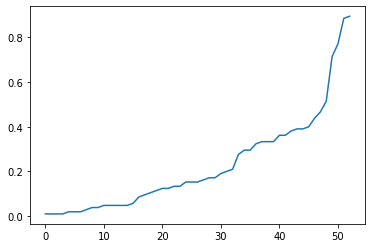

In [46]:
#Visual
fakesbyfeatureDF["%missing"].plot() 

<AxesSubplot:>

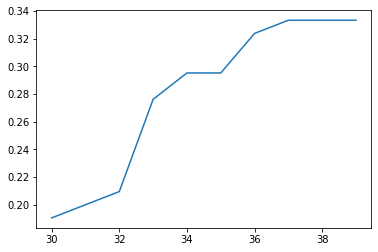

In [47]:
#Zoom 
fakesbyfeatureDF['%missing'].iloc[30:40].plot() #Zoom: [20:30] original

In [48]:
# Major jump at 32nd variable. Cutoff at 33
fakesbyfeatureDF = fakesbyfeatureDF.iloc[33:] 

In [49]:
#Filter these out of original DF
completeDF = completeDF.iloc[:,~completeDF.columns.isin(fakesbyfeatureDF['feature'])]

In [50]:
nullstats(completeDF) #3.22% for 1990

Total nulls: 61,277
Total cells: 1,902,600
3.22 % of DF is null


---

## Imputation

In [51]:
# Remove and store non-numeric variables
object_cols = completeDF.select_dtypes(include=object).columns
saved_cols = completeDF[object_cols]

#Drop them from the DF
completeDF = completeDF.drop(object_cols, axis=1)

# Save the names of the DF columns
col_names = completeDF.columns

In [52]:
# Run imputation
imputer = KNNImputer(n_neighbors=5, weights="uniform")
completeDF = pd.DataFrame(imputer.fit_transform(completeDF), columns=col_names)

In [53]:
#Add columns back
completeDF = pd.concat([completeDF, saved_cols.reset_index(drop=True)], axis=1)

In [54]:
nullstats(completeDF)

Total nulls: 30
Total cells: 1,902,600
0.0 % of DF is null


---

## Add continents to DF

In [55]:
# Load and clean
continents = pd.read_csv('CountryContinents.csv')
continents = continents.drop(['Country or Area'], axis=1)
continents.columns = ['alpha3_code', 'Continent', 'Region1']

In [56]:
# Merge
completeDF = pd.merge(completeDF, continents, on=['alpha3_code'])

---

## Clean

In [57]:
#View
completeDF.head(2)

,SPURBGROW,SPPOPAG25FEIN,SPPOPAG25MAIN,SPPOPDPND,SPPOPDPNDOL,SPPOPDPNDYG,SPPOPGROW,SPPOPTOTL,SPPOPTOTLFEIN,SPPOPTOTLFEZS,...,SEPRMENRRMA,NVINDMANFKDZG,CountryName,short_name,alpha3_code,iso3166-2,CountryCode,alpha2_code,Continent,Region1
0,2.543043,29833.0,30896.0,61.994909,8.901594,53.093316,1.799086,3286542.0,1603543.0,48.791200,...,99.233337,-1.330062,Albania,Albania,ALB,ISO 3166-2:AL,ALB,AL,Europe,Southern Europe
1,0.141061,28894.0,29109.0,62.715405,9.191396,53.524009,-0.602810,3266790.0,1604790.0,49.124359,...,101.039749,4.437151,Albania,Albania,ALB,ISO 3166-2:AL,ALB,AL,Europe,Southern Europe


In [58]:
# Move CountryName back
country_name = completeDF.pop("CountryName")
completeDF.insert(0, "CountryName", country_name)

#Move year back to original position (important for later analysis)
year = completeDF.pop("Year")
completeDF.insert(1, "Year", year)

#Move ISO3 code to end of DF
completeDF['ISO3'] = completeDF.pop('alpha3_code')

completeDF.head()

,CountryName,Year,SPURBGROW,SPPOPAG25FEIN,SPPOPAG25MAIN,SPPOPDPND,SPPOPDPNDOL,SPPOPDPNDYG,SPPOPGROW,SPPOPTOTL,...,SEENRPRIMFMZS,SEPRMENRRMA,NVINDMANFKDZG,short_name,iso3166-2,CountryCode,alpha2_code,Continent,Region1,ISO3
0,Albania,1990.0,2.543043,29833.0,30896.0,61.994909,8.901594,53.093316,1.799086,3286542.0,...,1.00459,99.233337,-1.330062,Albania,ISO 3166-2:AL,ALB,AL,Europe,Southern Europe,ALB
1,Albania,1991.0,0.141061,28894.0,29109.0,62.715405,9.191396,53.524009,-0.602810,3266790.0,...,1.00398,101.039749,4.437151,Albania,ISO 3166-2:AL,ALB,AL,Europe,Southern Europe,ALB
2,Albania,1992.0,0.878430,27689.0,26863.0,63.311979,9.516996,53.794984,-0.606435,3247039.0,...,1.01642,98.775101,4.437151,Albania,ISO 3166-2:AL,ALB,AL,Europe,Southern Europe,ALB
3,Albania,1993.0,0.855535,26544.0,24681.0,63.743013,9.867033,53.875979,-0.610166,3227287.0,...,1.03497,96.882889,5.424634,Albania,ISO 3166-2:AL,ALB,AL,Europe,Southern Europe,ALB
4,Albania,1994.0,0.843726,25748.0,23079.0,64.077234,10.223010,53.854224,-0.613881,3207536.0,...,0.98764,102.142090,8.645841,Albania,ISO 3166-2:AL,ALB,AL,Europe,Southern Europe,ALB


In [59]:
#Drop unnecessary columns and reset index
completeDF = completeDF.drop(['iso3166-2', 'CountryCode', 'short_name', 'numeric_code', 'alpha2_code'], axis=1)
completeDF = completeDF.reset_index(drop=True)
completeDF.head(2)

,CountryName,Year,SPURBGROW,SPPOPAG25FEIN,SPPOPAG25MAIN,SPPOPDPND,SPPOPDPNDOL,SPPOPDPNDYG,SPPOPGROW,SPPOPTOTL,...,NYGDPFCSTKD,NYGDPFCSTKN,NYTAXNINDCD,SEPRMENRRFE,SEENRPRIMFMZS,SEPRMENRRMA,NVINDMANFKDZG,Continent,Region1,ISO3
0,Albania,1990.0,2.543043,29833.0,30896.0,61.994909,8.901594,53.093316,1.799086,3286542.0,...,4.687984e+09,5.561554e+11,4.565230e+08,99.688721,1.00459,99.233337,-1.330062,Europe,Southern Europe,ALB
1,Albania,1991.0,0.141061,28894.0,29109.0,62.715405,9.191396,53.524009,-0.602810,3266790.0,...,3.484063e+09,4.133292e+11,5.590416e+08,101.441803,1.00398,101.039749,4.437151,Europe,Southern Europe,ALB


In [60]:
completeDF.shape #3150 x 601

(3150, 601)

### Export

In [61]:
completeDF.to_csv("completeDF.csv", index=False)